In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
import operator
from wordcloud import WordCloud, STOPWORDS
import ast
import warnings; warnings.simplefilter('ignore')

### Load Data 

In [2]:
movies = pd.read_csv("C:/Users/varsut/Desktop/Project/Datasets/Input/movies_metadata.csv")
ratings = pd.read_csv("C:/Users/varsut/Desktop/Project/Datasets/Input/ratings.csv")
credits = pd.read_csv("C:/Users/varsut/Desktop/Project/Datasets/Input/credits.csv")
keywords = pd.read_csv('C:/Users/varsut/Desktop/Project/Datasets/Input/keywords.csv')


### Data Wrangling

In [3]:

#Drop the IMDB id column since the metadata is already available for the movies 
movies = movies.drop(['imdb_id'],axis = 1)

In [4]:
movies.shape


(45466, 23)

In [5]:
#Since the scraped data is in json format folllowing cleans the data to make further calculations easier 
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

#Eliminate the extra title column since it is not necessary, only 4 movies have a different title from its original title 
movies[movies['original_title'] != movies['title']][['title', 'original_title']].head()
movies = movies.drop('original_title', axis=1)

#Clean the numeric columns 
movies[movies['revenue'] == 0].shape
movies['revenue'] = movies['revenue'].replace(0, np.nan)
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce')
movies['budget'] = movies['budget'].replace(0, np.nan)
movies[movies['budget'].isnull()].shape
movies['return'] = movies['revenue'] / movies['budget']
movies[movies['return'].isnull()].shape

#Change the date time format to make the analysis easier 
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

#Drop isAdult Column since only a few values are true
movies['adult'].value_counts()
movies = movies.drop('adult', axis=1)
                     
#get the poster URL since it is important later for displaying it on the UI                     
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
movies['poster_path'] = "<img src='" + base_poster_url + movies['poster_path'] + "' style='height:100px;'>"

### Exploratory Data Analysis 
Following word clouds help verify the most popular genre and other exploratory analysis 
They are made using the titles of the movie and the overview of the movies

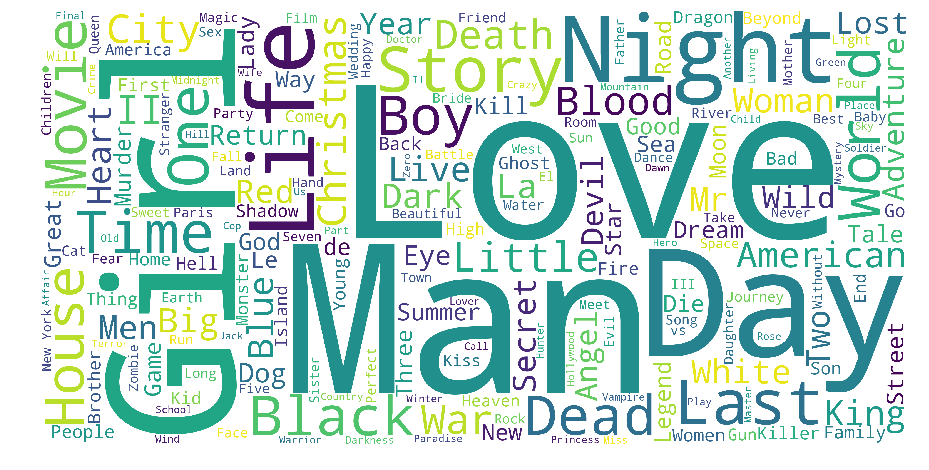

In [6]:
movies['title'] = movies['title'].astype('str')
movies['overview'] = movies['overview'].astype('str')
title_corpus = ' '.join(movies['title'])
overview_corpus = ' '.join(movies['overview'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

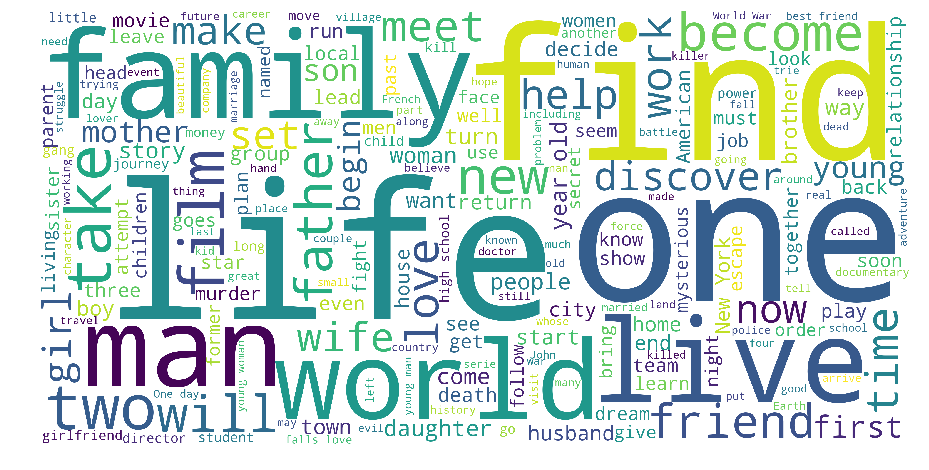

In [7]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

Following describes the analysis of which factors affect the rating of the movie, this inturn will help us decide which features to consider while constructing the models.

In [8]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [9]:
movies['popularity'] = movies['popularity'].apply(clean_numeric).astype('float')
movies['vote_count'] = movies['vote_count'].apply(clean_numeric).astype('float')
movies['vote_average'] = movies['vote_average'].apply(clean_numeric).astype('float')

In [10]:
movies['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

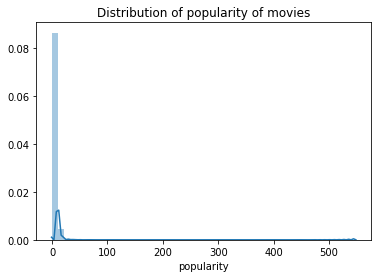

In [11]:
sns.distplot(movies['popularity'].fillna(movies['popularity'].median())).set_title("Distribution of popularity of movies")
plt.show()

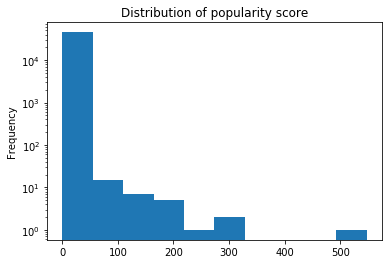

In [12]:
movies['popularity'].plot(logy=True, kind='hist',title="Distribution of popularity score")

Following cells do an analysis of how the popularity of a movie, the number of people rating and the rating that the movie gets are correlated.

In [13]:
movies[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10)

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014
26564,Deadpool,187.860492,2016
26566,Guardians of the Galaxy Vol. 2,185.330992,2017
14551,Avatar,185.070892,2009
24351,John Wick,183.870374,2014
23675,Gone Girl,154.801009,2014


In [14]:
movies['vote_count'].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [15]:
movies[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


In [16]:
movies['vote_average'] = movies['vote_average'].replace(0, np.nan)
movies['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

Text(0.5, 1.0, 'Distribution of the ratings')

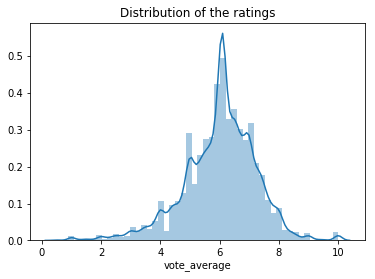

In [17]:
#Shows the distribution of the ratings 
sns.distplot(movies['vote_average'].fillna(movies['vote_average'].median())).set_title("Distribution of the ratings")

The correlation coefficient between the two attributes is 0.09664429948684439


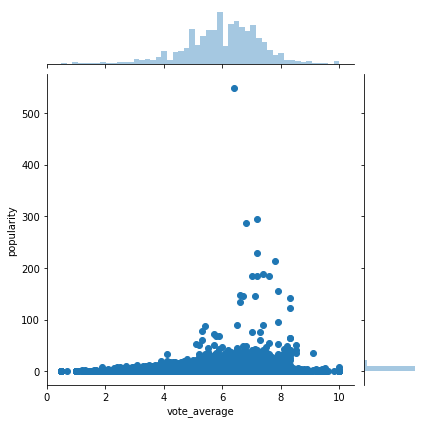

In [18]:
#This plot helps verify the relationship between popularity and vote average

sns.jointplot(x='vote_average', y='popularity', data=movies)
print("The correlation coefficient between the two attributes is",movies['vote_average'].corr(movies['popularity']))

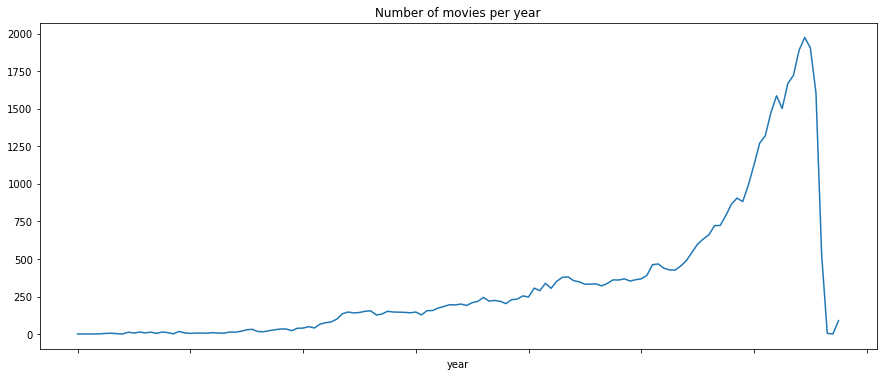

In [19]:
year_count = movies.groupby('year')['title'].count()
plt.figure(figsize=(15,6))
year_count.plot(title="Number of movies per year")

Since the choice of a user watching a movie also depends on the language of the movie, the following graph shows the distribution of the same

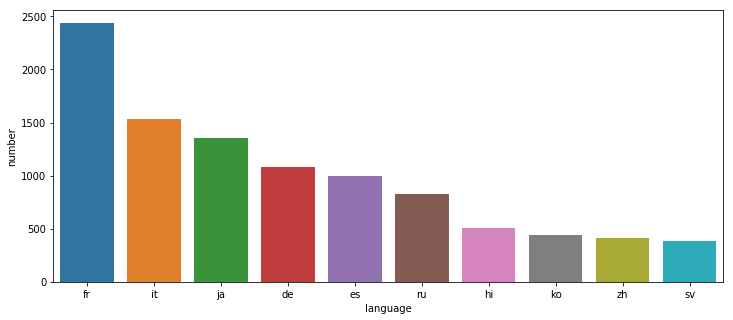

In [20]:

lang_df = pd.DataFrame(movies['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

Text(0.5, 1.0, 'Distribution of Runtime of the movies')

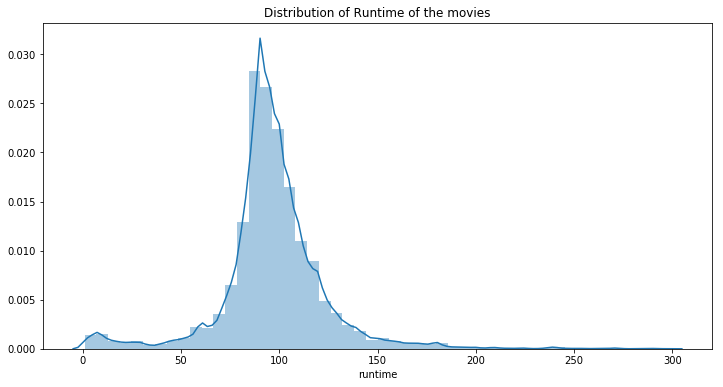

In [21]:
movies['runtime'] = movies['runtime'].astype('float')
plt.figure(figsize=(12,6))
sns.distplot(movies[(movies['runtime'] < 300) & (movies['runtime'] > 0)]['runtime']).set_title("Distribution of Runtime of the movies")

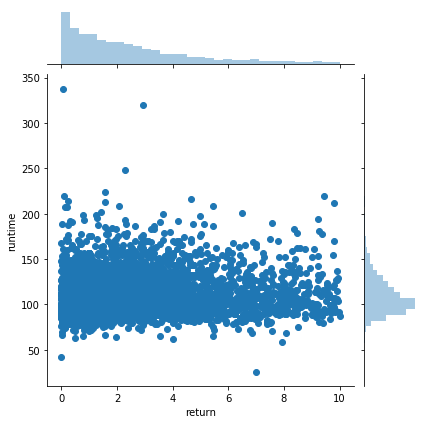

The correlation coefficient between the two attributes is -0.0137343917439841


In [22]:
#The duration of a movie is independent of its success 
movies_mat = movies[(movies['return'].notnull()) & (movies['runtime'] > 0) & (movies['return'] < 10)]
sns.jointplot('return', 'runtime', data=movies_mat)
plt.show()
print("The correlation coefficient between the two attributes is",movies['return'].corr(movies['runtime']))

#### Correlation Plot
Following plot helps us know which atrributes are highly correlated and they help us narrow down attributes for the model

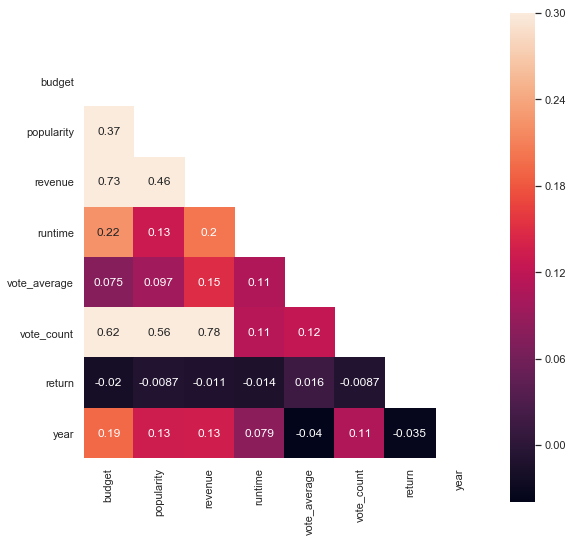

In [23]:
movies['year'] = movies['year'].replace('NaT', np.nan)
movies['year'] = movies['year'].apply(clean_numeric)
sns.set(font_scale=1)
corr = movies.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

In [24]:
#movies['genres'] = movies['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


In [25]:
s = movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_movies = movies.drop('genres', axis=1).join(s)
gen_movies['genre'].value_counts().shape[0]
pop_gen = pd.DataFrame(gen_movies['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)


,genre,movies
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


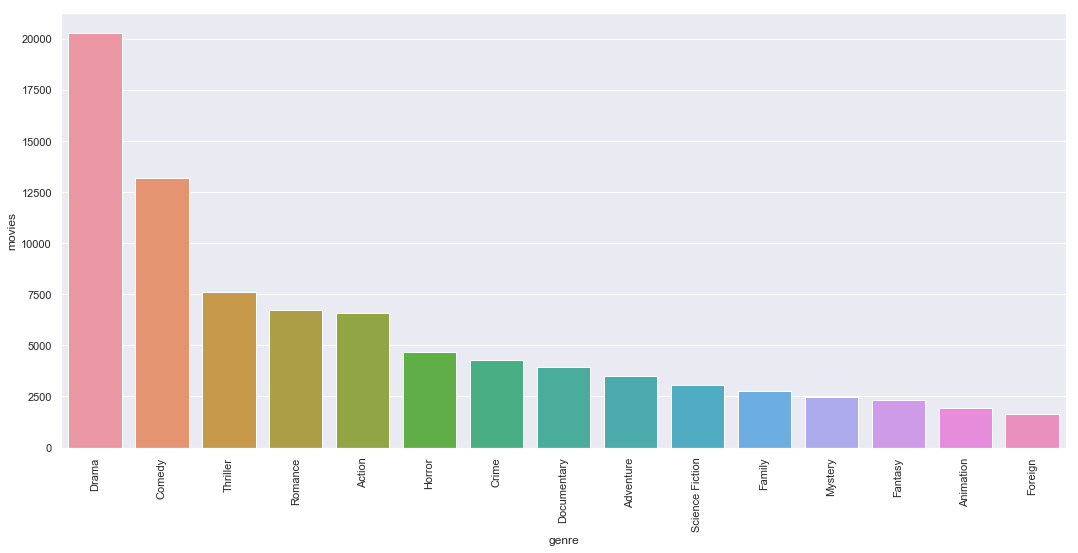

In [26]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.xticks(rotation = "vertical")
plt.show()

### Cast and crew data

In [27]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
movies['id'] = movies['id'].apply(convert_int)



In [28]:
credits.head()


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [29]:
movies[movies['id'].isnull()]
movies = movies.drop([19730, 29503, 35587])

In [30]:
movies['id'] = movies['id'].astype('int')

In [32]:
movies = movies.merge(credits, on='id')
print(movies.shape)
movies['cast'] = movies['cast'].apply(ast.literal_eval)
movies['crew'] = movies['crew'].apply(ast.literal_eval)
movies['cast_size'] = movies['cast'].apply(lambda x: len(x))
movies['crew_size'] = movies['crew'].apply(lambda x: len(x))
movies['cast'] = movies['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

(45538, 25)


In [33]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
movies['director'] = movies['crew'].apply(get_director)

In [34]:
s = movies.apply(lambda x: pd.Series(x['cast']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'actor'
cast_movies = movies.drop('cast', axis=1).join(s)

In [35]:
movies.head()

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,video,vote_average,vote_count,return,year,cast,crew,cast_size,crew_size,director
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,<img src='http://image.tmdb.org/t/p/w185//rhIR...,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,False,7.7,5415.0,12.451801,1995.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",13,106,John Lasseter
1,NaN,65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,en,When siblings Judy and Peter discover an encha...,17.015539,<img src='http://image.tmdb.org/t/p/w185//vzmL...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,False,6.9,2413.0,4.043035,1995.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",26,16,Joe Johnston
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[Romance, Comedy]",NaN,15602,en,A family wedding reignites the ancient feud be...,11.712900,<img src='http://image.tmdb.org/t/p/w185//6ksm...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,False,6.5,92.0,NaN,1995.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",7,4,Howard Deutch
3,NaN,16000000.0,"[Comedy, Drama, Romance]",NaN,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,<img src='http://image.tmdb.org/t/p/w185//16XO...,[{'name': 'Twentieth Century Fox Film Corporat...,...,False,6.1,34.0,5.090760,1995.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'credit_id': '52fe44779251416c91011acb', 'de...",10,10,Forest Whitaker
4,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,[Comedy],NaN,11862,en,Just when George Banks has recovered from his ...,8.387519,<img src='http://image.tmdb.org/t/p/w185//e64s...,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,False,5.7,173.0,NaN,1995.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",12,7,Charles Shyer


In [36]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies['id'] = movies['id'].astype('int')

In [37]:

movies = movies.merge(keywords, on='id')


In [38]:
movies.head()

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,vote_average,vote_count,return,year,cast,crew,cast_size,crew_size,director,keywords
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,<img src='http://image.tmdb.org/t/p/w185//rhIR...,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,7.7,5415.0,12.451801,1995.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",13,106,John Lasseter,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,NaN,65000000.0,"[Adventure, Fantasy, Family]",NaN,8844,en,When siblings Judy and Peter discover an encha...,17.015539,<img src='http://image.tmdb.org/t/p/w185//vzmL...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,6.9,2413.0,4.043035,1995.0,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",26,16,Joe Johnston,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"[Romance, Comedy]",NaN,15602,en,A family wedding reignites the ancient feud be...,11.712900,<img src='http://image.tmdb.org/t/p/w185//6ksm...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,6.5,92.0,NaN,1995.0,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",7,4,Howard Deutch,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,NaN,16000000.0,"[Comedy, Drama, Romance]",NaN,31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,<img src='http://image.tmdb.org/t/p/w185//16XO...,[{'name': 'Twentieth Century Fox Film Corporat...,...,6.1,34.0,5.090760,1995.0,"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'credit_id': '52fe44779251416c91011acb', 'de...",10,10,Forest Whitaker,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"{'id': 96871, 'name': 'Father of the Bride Col...",NaN,[Comedy],NaN,11862,en,Just when George Banks has recovered from his ...,8.387519,<img src='http://image.tmdb.org/t/p/w185//e64s...,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,5.7,173.0,NaN,1995.0,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",12,7,Charles Shyer,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [39]:
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
print("Average Ratings:",C,"95th Percentile of vote counts:",m)

Average Ratings: 5.614532331103602 95th Percentile of vote counts: 425.0


In [40]:

qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2335, 6)

In [41]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [42]:
qualified.head(10)

,title,year,vote_count,vote_average,popularity,genres,wr
15651,Inception,2010.0,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.930081
12589,The Dark Knight,2008.0,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.920134
23076,Interstellar,2014.0,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.912692
2870,Fight Club,1999.0,9678,8,63.869599,[Drama],7.899651
4904,The Lord of the Rings: The Fellowship of the Ring,2001.0,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.891186
292,Pulp Fiction,1994.0,8670,8,140.950236,"[Thriller, Crime]",7.888530
314,The Shawshank Redemption,1994.0,8358,8,51.645403,"[Drama, Crime]",7.884570
7069,The Lord of the Rings: The Return of the King,2003.0,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.882808
351,Forrest Gump,1994.0,8147,8,48.307194,"[Comedy, Drama, Romance]",7.881728
5876,The Lord of the Rings: The Two Towers,2002.0,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.874309


In [43]:

def build_chart(genre, percentile=0.85):
    df = gen_movies[gen_movies['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [44]:
build_chart('Romance').head(10)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995.0,661,9,34.457024,8.593097
351,Forrest Gump,1994.0,8147,8,48.307194,7.973895
876,Vertigo,1958.0,1162,8,18.208220,7.828358
40251,Your Name.,2016.0,1030,8,34.461252,7.808145
883,Some Like It Hot,1959.0,835,8,11.845107,7.767739
1132,Cinema Paradiso,1988.0,834,8,14.177005,7.767488
19901,Paperman,2012.0,734,8,7.198633,7.739301
37863,Sing Street,2016.0,669,8,10.672862,7.717002
882,The Apartment,1960.0,498,8,11.994281,7.634827
38718,The Handmaiden,2016.0,453,8,16.727405,7.604614
